In [1]:
#CELL 1: INSTALL DEPENDENCIES

!pip install catboost keras-tuner optuna meteostat xgboost lightgbm holidays joblib pyarrow PyWavelets scipy tensorflow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 182.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 169.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 193.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

In [2]:
# ═══════════════════════════════════════════════════════════════════════════════
# CELL 1: INSTALL & IMPORTS (Run this first when resuming)
# ═══════════════════════════════════════════════════════════════════════════════

!pip install catboost xgboost lightgbm tensorflow -q

import os
import gc
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

warnings.filterwarnings('ignore')

print("✅ All imports ready!")

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


✅ All imports ready!


In [3]:
# CELL 3: MOUNT GOOGLE DRIVE & DATE-BASED DIRECTORIES
from google.colab import drive
drive.mount('/content/drive')
# DATE-BASED DIRECTORIES (crash-proof!)
BASE_DIR = f"/content/drive/MyDrive/citi_bike_project_{TODAY}"
CHECKPOINT_DIR = f"{BASE_DIR}/checkpoints"
OUTPUT_DIR = f"{BASE_DIR}/final_output"
PLOTS_DIR = f"{BASE_DIR}/plots"
for directory in [CHECKPOINT_DIR, OUTPUT_DIR, PLOTS_DIR]:
    os.makedirs(directory, exist_ok=True)
# Raw data path (update to your location)
RAW_DATA_PATH = "/content/drive/MyDrive/citi_bike_project/processed_data/citibike_master.parquet"
print(f"✅ Date-based directories created!")
print(f"📁 Base: {BASE_DIR}")
print(f"📁 Checkpoints: {CHECKPOINT_DIR}")
print(f"📁 Output: {OUTPUT_DIR}")
# CHECKPOINT 1
print(f"\n✅ CHECKPOINT 1 SAVED - Imports and directories ready")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Date-based directories created!
📁 Base: /content/drive/MyDrive/citi_bike_project_20251211
📁 Checkpoints: /content/drive/MyDrive/citi_bike_project_20251211/checkpoints
📁 Output: /content/drive/MyDrive/citi_bike_project_20251211/final_output

✅ CHECKPOINT 1 SAVED - Imports and directories ready


In [4]:
# CELL 4: LOAD RAW DATA
print("📊 Loading raw data...")
df_raw = pd.read_parquet(RAW_DATA_PATH)
print(f"\n{'='*60}")
print("📋 RAW DATA OVERVIEW")
print(f"{'='*60}")
print(f"Shape: {df_raw.shape}")
print(f"Memory: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Date Range: {df_raw['started_at'].min()} to {df_raw['started_at'].max()}")
print(f"Total Trips: {len(df_raw):,}")


📊 Loading raw data...

📋 RAW DATA OVERVIEW
Shape: (186184520, 13)
Memory: 107839.47 MB
Date Range: 2019-01-19 18:24:31.851 to 2025-08-31 23:58:17.885
Total Trips: 186,184,520


In [5]:
# CELL 5: AGGREGATE TO HOURLY DEMAND

print("🔄 Aggregating trips to hourly demand...")
df_raw['started_at'] = pd.to_datetime(df_raw['started_at'])
df_raw['ended_at'] = pd.to_datetime(df_raw['ended_at'])
df_raw['start_hour'] = df_raw['started_at'].dt.floor('h')
df_raw['end_hour'] = df_raw['ended_at'].dt.floor('h')
pickups = df_raw.groupby(['start_station_name', 'start_hour']).size().reset_index(name='pickups')
pickups.columns = ['station_name', 'time', 'pickups']
dropoffs = df_raw.groupby(['end_station_name', 'end_hour']).size().reset_index(name='dropoffs')
dropoffs.columns = ['station_name', 'time', 'dropoffs']
df_agg = pickups.merge(dropoffs, on=['station_name', 'time'], how='outer').fillna(0)
df_agg['pickups'] = df_agg['pickups'].astype(int)
df_agg['dropoffs'] = df_agg['dropoffs'].astype(int)
df_agg['net_demand'] = df_agg['dropoffs'] - df_agg['pickups']
print(f"✅ Aggregation: {df_agg.shape}")
del df_raw, pickups, dropoffs
gc.collect()


🔄 Aggregating trips to hourly demand...
✅ Aggregation: (50741221, 5)


40

In [6]:
# CELL 6: SELECT TOP 200 STATIONS + CHECKPOINT 2

print("🎯 Selecting top 200 stations...")
station_stats = df_agg.groupby('station_name').agg({
    'pickups': ['count', 'sum', 'mean', 'std'],
    'time': ['min', 'max']
}).reset_index()
station_stats.columns = ['station_name', 'data_points', 'total_pickups', 'mean_pickups', 'std_pickups', 'first_time', 'last_time']
station_stats['days_active'] = (station_stats['last_time'] - station_stats['first_time']).dt.total_seconds() / 86400
station_stats['coverage_ratio'] = station_stats['data_points'] / (station_stats['days_active'] * 24 + 1)
station_stats['coverage_ratio'] = station_stats['coverage_ratio'].clip(0, 1)
station_stats['cv'] = station_stats['std_pickups'] / (station_stats['mean_pickups'] + 1e-6)
station_stats['quality_score'] = station_stats['total_pickups'] * station_stats['coverage_ratio'] / (station_stats['cv'].clip(0.5, 3) + 1)
top_stations = station_stats.nlargest(TOP_N_STATIONS, 'quality_score')['station_name'].tolist()
df_filtered = df_agg[df_agg['station_name'].isin(top_stations)].copy()
print(f"✅ Selected {len(top_stations)} stations")
# CHECKPOINT 2
df_filtered.to_parquet(f"{CHECKPOINT_DIR}/checkpoint_02_filtered.parquet", index=False)
with open(f"{CHECKPOINT_DIR}/top_stations.json", 'w') as f:
    json.dump(top_stations, f)
print(f"✅ CHECKPOINT 2 SAVED - Filtered data ({len(df_filtered):,} rows)")
del df_agg, station_stats
gc.collect()


🎯 Selecting top 200 stations...
✅ Selected 200 stations
✅ CHECKPOINT 2 SAVED - Filtered data (8,153,866 rows)


51

In [7]:
# CELL 7: CREATE COMPLETE TIME GRID
# ═══════════════════════════════════════════════════════════════════════════════
print("🕐 Creating complete hourly grid...")
from itertools import product
min_time, max_time = df_filtered['time'].min(), df_filtered['time'].max()
time_grid = pd.date_range(start=min_time, end=max_time, freq='h')
grid = pd.DataFrame(list(product(top_stations, time_grid)), columns=['station_name', 'time'])
df_complete = grid.merge(df_filtered, on=['station_name', 'time'], how='left')
df_complete['pickups'] = df_complete['pickups'].fillna(0).astype('float32')
df_complete['dropoffs'] = df_complete['dropoffs'].fillna(0).astype('float32')
df_complete['net_demand'] = df_complete['net_demand'].fillna(0).astype('float32')
print(f"✅ Complete grid: {df_complete.shape}")
del df_filtered, grid
gc.collect()


🕐 Creating complete hourly grid...
✅ Complete grid: (11598000, 5)


0

In [8]:
# CELL 8: FETCH WEATHER DATA

print("🌤️ Fetching weather data...")
try:
    weather_data = []
    start, end = df_complete['time'].min(), df_complete['time'].max()
    current = start
    while current < end:
        chunk_end = min(current + pd.DateOffset(months=6), end)
        weather_chunk = Hourly(NYC_COORDS, current, chunk_end).fetch()
        if not weather_chunk.empty:
            weather_data.append(weather_chunk)
        current = chunk_end + pd.Timedelta(hours=1)

    weather = pd.concat(weather_data).reset_index()[['time', 'temp', 'prcp', 'wspd', 'coco']]
    weather = weather.fillna(method='ffill').fillna(method='bfill')
except Exception as e:
    print(f"⚠️ Weather API error: {e}, using synthetic data")
    unique_times = df_complete['time'].unique()
    weather = pd.DataFrame({'time': unique_times})
    days = (weather['time'] - weather['time'].min()).dt.total_seconds() / 86400
    weather['temp'] = 15 + 15 * np.sin(2 * np.pi * days / 365)
    weather['prcp'] = np.random.exponential(0.3, len(weather)).clip(0, 10)
    weather['wspd'] = 10 + 5 * np.sin(2 * np.pi * days / 365)
    weather['coco'] = 0
df_complete = df_complete.merge(weather, on='time', how='left')
for col in ['temp', 'prcp', 'wspd', 'coco']:
    df_complete[col] = df_complete[col].fillna(df_complete[col].median()).astype('float32')
print(f"✅ Weather merged")


🌤️ Fetching weather data...
✅ Weather merged


In [9]:
# CELL 9: HOLIDAY + TEMPORAL FEATURES + CHECKPOINT 3

print("🎉 Adding holiday and temporal features...")
us_holidays = holidays.US(state='NY', years=range(2020, 2026))
df_complete['is_holiday'] = df_complete['time'].apply(lambda x: 1 if x.date() in us_holidays else 0).astype('int8')
df_complete['day_of_week'] = df_complete['time'].dt.dayofweek.astype('int8')
df_complete['is_weekend'] = (df_complete['day_of_week'] >= 5).astype('int8')
# Holiday proximity
sample_dates = df_complete['time'].dt.date.unique()
holiday_dates = sorted(list(us_holidays.keys()))
proximity_cache = {}
for date in sample_dates:
    future = [h for h in holiday_dates if h > date]
    past = [h for h in holiday_dates if h < date]
    proximity_cache[date] = {
        'to': (min(future) - date).days if future else 30,
        'since': (date - max(past)).days if past else 30
    }
df_complete['days_to_holiday'] = df_complete['time'].dt.date.map(lambda x: min(proximity_cache.get(x, {'to': 30})['to'], 30)).astype('int8')
df_complete['days_since_holiday'] = df_complete['time'].dt.date.map(lambda x: min(proximity_cache.get(x, {'since': 30})['since'], 30)).astype('int8')
# Temporal
df_complete['hour'] = df_complete['time'].dt.hour.astype('int8')
df_complete['day'] = df_complete['time'].dt.day.astype('int8')
df_complete['month'] = df_complete['time'].dt.month.astype('int8')
df_complete['year'] = df_complete['time'].dt.year.astype('int16')
df_complete['quarter'] = df_complete['time'].dt.quarter.astype('int8')
df_complete['hour_sin'] = np.sin(2 * np.pi * df_complete['hour'] / 24).astype('float32')
df_complete['hour_cos'] = np.cos(2 * np.pi * df_complete['hour'] / 24).astype('float32')
df_complete['month_sin'] = np.sin(2 * np.pi * df_complete['month'] / 12).astype('float32')
df_complete['month_cos'] = np.cos(2 * np.pi * df_complete['month'] / 12).astype('float32')
df_complete['day_sin'] = np.sin(2 * np.pi * df_complete['day'] / 31).astype('float32')
df_complete['day_cos'] = np.cos(2 * np.pi * df_complete['day'] / 31).astype('float32')
df_complete['is_morning_rush'] = ((df_complete['hour'] >= 7) & (df_complete['hour'] <= 9)).astype('int8')
df_complete['is_evening_rush'] = ((df_complete['hour'] >= 17) & (df_complete['hour'] <= 19)).astype('int8')
df_complete['is_rush_hour'] = (df_complete['is_morning_rush'] | df_complete['is_evening_rush']).astype('int8')
df_complete['is_business_hours'] = ((df_complete['hour'] >= 9) & (df_complete['hour'] <= 17) & (df_complete['day_of_week'] < 5)).astype('int8')
df_complete['time_of_day'] = df_complete['hour'].apply(lambda h: 1 if 5<=h<12 else (2 if 12<=h<17 else (3 if 17<=h<21 else 4))).astype('int8')
df_complete['season'] = df_complete['month'].apply(lambda m: 1 if m in [12,1,2] else (2 if m in [3,4,5] else (3 if m in [6,7,8] else 4))).astype('int8')
df_complete['week_of_year'] = df_complete['time'].dt.isocalendar().week.astype('int8')
df_complete['is_month_start'] = (df_complete['day'] <= 3).astype('int8')
df_complete['is_month_end'] = (df_complete['day'] >= 28).astype('int8')
df_complete['days_since_epoch'] = ((df_complete['time'] - pd.Timestamp('2020-01-01')).dt.total_seconds() / 86400).astype('float32')
# CHECKPOINT 3
df_complete.to_parquet(f"{CHECKPOINT_DIR}/checkpoint_03_temporal.parquet", index=False)
print(f"✅ CHECKPOINT 3 SAVED - Temporal features ({df_complete.shape[1]} columns)")
gc.collect()

🎉 Adding holiday and temporal features...
✅ CHECKPOINT 3 SAVED - Temporal features (35 columns)


0

In [10]:
# CELL 10: LAG & ROLLING FEATURES

print("🔄 Creating lag and rolling features...")
df_complete = df_complete.sort_values(['station_name', 'time']).reset_index(drop=True)
grouped = df_complete.groupby('station_name')['pickups']
# Lag features
for lag in [1, 2, 3, 6, 12, 24, 48, 168]:
    df_complete[f'lag_{lag}h'] = grouped.shift(lag).astype('float32')
# Rolling features
for window in [4, 12, 24, 168]:
    df_complete[f'roll_mean_{window}h'] = grouped.transform(lambda x: x.shift(1).rolling(window, min_periods=1).mean()).astype('float32')
    df_complete[f'roll_std_{window}h'] = grouped.transform(lambda x: x.shift(1).rolling(window, min_periods=1).std()).fillna(1.0).astype('float32')
    df_complete[f'roll_min_{window}h'] = grouped.transform(lambda x: x.shift(1).rolling(window, min_periods=1).min()).astype('float32')
    df_complete[f'roll_max_{window}h'] = grouped.transform(lambda x: x.shift(1).rolling(window, min_periods=1).max()).astype('float32')
# EMA and change
df_complete['ema_24h'] = grouped.transform(lambda x: x.shift(1).ewm(span=24, adjust=False).mean()).astype('float32')
df_complete['demand_change_1h'] = (df_complete['pickups'] - df_complete['lag_1h']).astype('float32')
df_complete['demand_change_24h'] = (df_complete['pickups'] - df_complete['lag_24h']).astype('float32')
print(f"✅ Lag features: {df_complete.shape[1]} columns")


🔄 Creating lag and rolling features...
✅ Lag features: 62 columns


In [11]:
# CELL 11: FOURIER + WEATHER INTERACTIONS

print("📊 Adding Fourier and weather interaction features...")
# Fourier (sample stations for speed)
fourier_data = []
for station in top_stations[:50]:
    signal = df_complete[df_complete['station_name'] == station]['pickups'].values
    if len(signal) > 168:
        fft_vals = fft(signal)
        power = np.abs(fft_vals) ** 2
        freqs = np.fft.fftfreq(len(signal))
        top_idx = np.argsort(power[1:])[-3:] + 1
        fourier_data.append({'station_name': station, 'dominant_freq_1': freqs[top_idx[0]],
                             'dominant_freq_2': freqs[top_idx[1]], 'dominant_freq_3': freqs[top_idx[2]],
                             'power_1': power[top_idx[0]], 'power_2': power[top_idx[1]], 'power_3': power[top_idx[2]]})
df_fourier = pd.DataFrame(fourier_data)
df_complete = df_complete.merge(df_fourier, on='station_name', how='left')
for col in ['dominant_freq_1', 'dominant_freq_2', 'dominant_freq_3', 'power_1', 'power_2', 'power_3']:
    if col in df_complete.columns:
        df_complete[col] = df_complete[col].fillna(df_complete[col].median()).astype('float32')
# Weather interactions
df_complete['temp_hour_interaction'] = (df_complete['temp'] * df_complete['hour'] / 24).astype('float32')
df_complete['temp_weekend_interaction'] = (df_complete['temp'] * df_complete['is_weekend']).astype('float32')
df_complete['temp_rush_interaction'] = (df_complete['temp'] * df_complete['is_rush_hour']).astype('float32')
df_complete['rain_weekend'] = (df_complete['prcp'] * df_complete['is_weekend']).astype('float32')
df_complete['rain_rush_hour'] = (df_complete['prcp'] * df_complete['is_rush_hour']).astype('float32')
df_complete['feels_like'] = (df_complete['temp'] - 0.4 * df_complete['wspd']).astype('float32')
df_complete['is_hot'] = (df_complete['temp'] > df_complete['temp'].quantile(0.9)).astype('int8')
df_complete['is_cold'] = (df_complete['temp'] < df_complete['temp'].quantile(0.1)).astype('int8')
df_complete['is_rainy'] = (df_complete['prcp'] > 1.0).astype('int8')
df_complete['is_windy'] = (df_complete['wspd'] > df_complete['wspd'].quantile(0.9)).astype('int8')
df_complete['bad_weather'] = (df_complete['is_rainy'] | df_complete['is_cold'] | df_complete['is_windy']).astype('int8')
print(f"✅ Fourier + Weather: {df_complete.shape[1]} columns")

📊 Adding Fourier and weather interaction features...
✅ Fourier + Weather: 79 columns


In [12]:
# CELL 12: OUTLIER DETECTION + REMOVAL + CHECKPOINT 4

print("🔍 Detecting and REMOVING outliers (clean data)...")
feature_cols = ['pickups', 'temp', 'prcp', 'roll_mean_24h', 'lag_24h']
feature_data = df_complete[feature_cols].fillna(df_complete[feature_cols].median())
# IQR
Q1, Q3 = df_complete['pickups'].quantile(0.25), df_complete['pickups'].quantile(0.75)
IQR = Q3 - Q1
iqr_outliers = (df_complete['pickups'] < Q1 - 4*IQR) | (df_complete['pickups'] > Q3 + 4*IQR)
# Z-score
z_scores = np.abs(stats.zscore(df_complete['pickups'].fillna(df_complete['pickups'].median())))
zscore_outliers = z_scores > 4
# Isolation Forest (10% sample)
sample_idx = np.random.choice(len(feature_data), int(len(feature_data)*0.1), replace=False)
iso_forest = IsolationForest(contamination=0.05, random_state=RANDOM_STATE, n_jobs=-1)
iso_forest.fit(feature_data.iloc[sample_idx])
iso_outliers = iso_forest.predict(feature_data) == -1
# LOF (5% sample)
sample_lof = np.random.choice(len(feature_data), int(len(feature_data)*0.05), replace=False)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, n_jobs=-1)
lof_preds = lof.fit_predict(feature_data.iloc[sample_lof])
lof_outliers = np.zeros(len(feature_data), dtype=bool)
lof_outliers[sample_lof[lof_preds == -1]] = True
# Consensus (2+ methods agree)
outlier_count = iqr_outliers.astype(int) + zscore_outliers.astype(int) + iso_outliers.astype(int) + lof_outliers.astype(int)
is_outlier = outlier_count >= 2
print(f"   Outliers detected: {is_outlier.sum():,} ({is_outlier.mean()*100:.2f}%)")
# REMOVE outliers (clean data for better models)
df_clean = df_complete[~is_outlier].copy()
print(f"✅ Clean data: {len(df_clean):,} rows (removed {is_outlier.sum():,} outliers)")
# CHECKPOINT 4
df_clean.to_parquet(f"{CHECKPOINT_DIR}/checkpoint_04_clean_data.parquet", index=False)
print(f"✅ CHECKPOINT 4 SAVED - Clean data (no outliers)")
del feature_data, df_complete
gc.collect()
df_complete = df_clean  # Use clean data going forward


🔍 Detecting and REMOVING outliers (clean data)...
   Outliers detected: 87,884 (0.76%)
✅ Clean data: 11,510,116 rows (removed 87,884 outliers)
✅ CHECKPOINT 4 SAVED - Clean data (no outliers)


In [13]:

# CELL 13: WAVELET DENOISING

print("🎵 Applying wavelet denoising...")
def wavelet_denoise(signal, wavelet='db4', level=3):
    if len(signal) < 100: return signal
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(len(signal)))
        new_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
        denoised = pywt.waverec(new_coeffs, wavelet)
        if len(denoised) > len(signal): denoised = denoised[:len(signal)]
        elif len(denoised) < len(signal): denoised = np.pad(denoised, (0, len(signal) - len(denoised)), mode='edge')
        return denoised
    except: return signal
df_complete['pickups_denoised'] = df_complete['pickups'].copy()
for i, station in enumerate(top_stations[:100]):
    mask = df_complete['station_name'] == station
    df_complete.loc[mask, 'pickups_denoised'] = wavelet_denoise(df_complete.loc[mask, 'pickups'].values)
df_complete['pickups_denoised'] = df_complete['pickups_denoised'].astype('float32')
print(f"✅ Wavelet denoising applied")


🎵 Applying wavelet denoising...
✅ Wavelet denoising applied


In [20]:
# ═══════════════════════════════════════════════════════════════════════════════
# CELL 14: PREPARE DATA + SCALING
# ═══════════════════════════════════════════════════════════════════════════════

print("✂️ Preparing train/test data...")

df_complete = df_complete.dropna(subset=['lag_24h', 'lag_168h', 'roll_mean_24h'])

# IMPORTANT: Sort by time FIRST for proper time-based split
df_complete = df_complete.sort_values('time').reset_index(drop=True)

# FEATURE LIST (54 features - removed demand_change features to prevent leakage)
FEATURE_COLS = [
    'temp', 'prcp', 'wspd', 'is_holiday', 'day_of_week', 'is_weekend',
    'days_to_holiday', 'days_since_holiday',
    'hour', 'day', 'month', 'year', 'quarter',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'is_morning_rush', 'is_evening_rush', 'is_rush_hour', 'is_business_hours',
    'time_of_day', 'season', 'week_of_year',
    'is_month_start', 'is_month_end', 'days_since_epoch',
    'lag_1h', 'lag_2h', 'lag_3h', 'lag_6h', 'lag_12h', 'lag_24h', 'lag_48h', 'lag_168h',
    'roll_mean_4h', 'roll_std_4h', 'roll_min_4h', 'roll_max_4h',
    'roll_mean_12h', 'roll_std_12h', 'roll_min_12h', 'roll_max_12h',
    'roll_mean_24h', 'roll_std_24h', 'roll_min_24h', 'roll_max_24h',
    'roll_mean_168h', 'roll_std_168h', 'roll_min_168h', 'roll_max_168h',
    'ema_24h'
]

print(f"Feature count: {len(FEATURE_COLS)}")

X = df_complete[FEATURE_COLS].fillna(df_complete[FEATURE_COLS].median())
y = df_complete['pickups']

split_idx = int(len(X) * TRAIN_TEST_SPLIT)

# Verify time-based split
print(f"\nTrain: {split_idx:,} rows")
print(f"  Dates: {df_complete.iloc[:split_idx]['time'].min()} to {df_complete.iloc[:split_idx]['time'].max()}")
print(f"Test: {len(X) - split_idx:,} rows")
print(f"  Dates: {df_complete.iloc[split_idx:]['time'].min()} to {df_complete.iloc[split_idx:]['time'].max()}")

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]
y_train_unscaled, y_test_unscaled = y.iloc[:split_idx].values, y.iloc[split_idx:].values

print(f"\n✅ Data prepared!")
print(f"   X_train: {X_train.shape}")
print(f"   X_test: {X_test.shape}")

✂️ Preparing train/test data...
Feature count: 54

Train: 9,181,229 rows
  Dates: 2019-01-26 18:00:00 to 2024-05-02 13:00:00
Test: 2,295,308 rows
  Dates: 2024-05-02 13:00:00 to 2025-08-31 23:00:00

✅ Data prepared!
   X_train: (9181229, 54)
   X_test: (2295308, 54)


In [21]:
# CELL 15: SAVE SCALERS + CHECKPOINT 5

joblib.dump(scaler_X, f"{OUTPUT_DIR}/scaler_tree.save")
joblib.dump(scaler_y, f"{OUTPUT_DIR}/scaler_y.save")
with open(f"{OUTPUT_DIR}/feature_names.json", 'w') as f:
    json.dump(FEATURE_COLS, f)
# CHECKPOINT 5
np.save(f"{CHECKPOINT_DIR}/X_train.npy", X_train)
np.save(f"{CHECKPOINT_DIR}/X_test.npy", X_test)
np.save(f"{CHECKPOINT_DIR}/y_train.npy", y_train)
np.save(f"{CHECKPOINT_DIR}/y_test.npy", y_test)
np.save(f"{CHECKPOINT_DIR}/y_train_unscaled.npy", y_train_unscaled)
np.save(f"{CHECKPOINT_DIR}/y_test_unscaled.npy", y_test_unscaled)
print(f"✅ CHECKPOINT 5 SAVED - Scalers and split data")
gc.collect()


✅ CHECKPOINT 5 SAVED - Scalers and split data


143

In [22]:
# CELL 16: TRAIN XGBOOST (Optuna)

print("\n🚀 TRAINING XGBOOST...")
def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 800, step=100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 3),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-6, 5.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 5.0, log=True),
        'tree_method': 'hist', 'random_state': RANDOM_STATE, 'n_jobs': -1
    }
    model = xgb.XGBRegressor(**params)
    sample_idx = np.random.choice(len(X_train), int(len(X_train)*0.1), replace=False)
    tscv = TimeSeriesSplit(n_splits=3)
    scores = []
    for tr_idx, val_idx in tscv.split(X_train[sample_idx]):
        model.fit(X_train[sample_idx][tr_idx], y_train[sample_idx][tr_idx], eval_set=[(X_train[sample_idx][val_idx], y_train[sample_idx][val_idx])], verbose=False)
        scores.append(mean_absolute_error(y_train[sample_idx][val_idx], model.predict(X_train[sample_idx][val_idx])))
    return np.mean(scores)
study_xgb = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RANDOM_STATE))
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)
best_xgb = study_xgb.best_params
best_xgb.update({'tree_method': 'hist', 'random_state': RANDOM_STATE, 'n_jobs': -1})
model_xgb = xgb.XGBRegressor(**best_xgb)
model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=50)
y_pred_xgb = scaler_y.inverse_transform(model_xgb.predict(X_test).reshape(-1, 1)).ravel()
mae_xgb = mean_absolute_error(y_test_unscaled, y_pred_xgb)
r2_xgb = r2_score(y_test_unscaled, y_pred_xgb)
print(f"📊 XGBoost: MAE={mae_xgb:.4f}, R²={r2_xgb:.4f}")
model_xgb.save_model(f"{OUTPUT_DIR}/xgb.json")


🚀 TRAINING XGBOOST...


  0%|          | 0/50 [00:00<?, ?it/s]

[0]	validation_0-rmse:1.19768
[50]	validation_0-rmse:0.55895
[100]	validation_0-rmse:0.54501
[150]	validation_0-rmse:0.54414
[200]	validation_0-rmse:0.54446
[250]	validation_0-rmse:0.54460
[300]	validation_0-rmse:0.54538
[350]	validation_0-rmse:0.54589
[400]	validation_0-rmse:0.54628
[450]	validation_0-rmse:0.54670
[500]	validation_0-rmse:0.54719
[550]	validation_0-rmse:0.54754
[600]	validation_0-rmse:0.54822
[650]	validation_0-rmse:0.54938
[699]	validation_0-rmse:0.55004
📊 XGBoost: MAE=2.7088, R²=0.7733


In [23]:
# CELL 17: TRAIN LIGHTGBM (Optuna)
# ═══════════════════════════════════════════════════════════════════════════════
print("\n🚀 TRAINING LIGHTGBM...")
def objective_lgb(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 30, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 800, step=100),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 80),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-6, 5.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 5.0, log=True),
        'random_state': RANDOM_STATE, 'n_jobs': -1, 'verbose': -1
    }
    model = lgb.LGBMRegressor(**params)
    sample_idx = np.random.choice(len(X_train), int(len(X_train)*0.1), replace=False)
    tscv = TimeSeriesSplit(n_splits=3)
    scores = []
    for tr_idx, val_idx in tscv.split(X_train[sample_idx]):
        model.fit(X_train[sample_idx][tr_idx], y_train[sample_idx][tr_idx], eval_set=[(X_train[sample_idx][val_idx], y_train[sample_idx][val_idx])], callbacks=[lgb.early_stopping(30, verbose=False)])
        scores.append(mean_absolute_error(y_train[sample_idx][val_idx], model.predict(X_train[sample_idx][val_idx])))
    return np.mean(scores)
study_lgb = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RANDOM_STATE))
study_lgb.optimize(objective_lgb, n_trials=50, show_progress_bar=True)
best_lgb = study_lgb.best_params
best_lgb.update({'random_state': RANDOM_STATE, 'n_jobs': -1, 'verbose': -1})
model_lgb = lgb.LGBMRegressor(**best_lgb)
model_lgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[lgb.log_evaluation(50), lgb.early_stopping(50)])
y_pred_lgb = scaler_y.inverse_transform(model_lgb.predict(X_test).reshape(-1, 1)).ravel()
mae_lgb = mean_absolute_error(y_test_unscaled, y_pred_lgb)
r2_lgb = r2_score(y_test_unscaled, y_pred_lgb)
print(f"📊 LightGBM: MAE={mae_lgb:.4f}, R²={r2_lgb:.4f}")
joblib.dump(model_lgb, f"{OUTPUT_DIR}/lgb.pkl")



🚀 TRAINING LIGHTGBM...


  0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.37078
[100]	valid_0's l2: 0.308389
[150]	valid_0's l2: 0.301333
[200]	valid_0's l2: 0.299344
[250]	valid_0's l2: 0.298125
[300]	valid_0's l2: 0.297248
[350]	valid_0's l2: 0.29645
[400]	valid_0's l2: 0.295903
[450]	valid_0's l2: 0.295369
[500]	valid_0's l2: 0.295041
[550]	valid_0's l2: 0.294869
[600]	valid_0's l2: 0.294677
[650]	valid_0's l2: 0.29446
[700]	valid_0's l2: 0.294379
[750]	valid_0's l2: 0.2943
[800]	valid_0's l2: 0.29428
Did not meet early stopping. Best iteration is:
[784]	valid_0's l2: 0.294256
📊 LightGBM: MAE=2.6655, R²=0.7795


['/content/drive/MyDrive/citi_bike_project_20251211/final_output/lgb.pkl']

In [24]:
# CELL 18: TRAIN CATBOOST + RANDOM FOREST + CHECKPOINT 6

print("\n🚀 TRAINING CATBOOST...")
model_cb = CatBoostRegressor(iterations=600, learning_rate=0.05, depth=8, l2_leaf_reg=3.0, random_state=RANDOM_STATE, verbose=100, thread_count=-1)
model_cb.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)
y_pred_cb = scaler_y.inverse_transform(model_cb.predict(X_test).reshape(-1, 1)).ravel()
mae_cb = mean_absolute_error(y_test_unscaled, y_pred_cb)
r2_cb = r2_score(y_test_unscaled, y_pred_cb)
print(f"📊 CatBoost: MAE={mae_cb:.4f}, R²={r2_cb:.4f}")
model_cb.save_model(f"{OUTPUT_DIR}/cb.cbm")
print("\n🚀 TRAINING RANDOM FOREST...")
model_rf = RandomForestRegressor(n_estimators=300, max_depth=20, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
model_rf.fit(X_train, y_train)
y_pred_rf = scaler_y.inverse_transform(model_rf.predict(X_test).reshape(-1, 1)).ravel()
mae_rf = mean_absolute_error(y_test_unscaled, y_pred_rf)
r2_rf = r2_score(y_test_unscaled, y_pred_rf)
print(f"📊 RandomForest: MAE={mae_rf:.4f}, R²={r2_rf:.4f}")
joblib.dump(model_rf, f"{OUTPUT_DIR}/rf.pkl")
# CHECKPOINT 6
print(f"✅ CHECKPOINT 6 SAVED - All tree models trained")



🚀 TRAINING CATBOOST...
0:	learn: 0.9009855	test: 1.2016789	best: 1.2016789 (0)	total: 250ms	remaining: 2m 29s
100:	learn: 0.4315348	test: 0.5598367	best: 0.5598367 (100)	total: 18.4s	remaining: 1m 30s
200:	learn: 0.4242593	test: 0.5506314	best: 0.5506314 (200)	total: 36.3s	remaining: 1m 12s
300:	learn: 0.4207255	test: 0.5473638	best: 0.5473638 (300)	total: 54.4s	remaining: 54s
400:	learn: 0.4181654	test: 0.5453337	best: 0.5453337 (400)	total: 1m 12s	remaining: 35.8s
500:	learn: 0.4161316	test: 0.5443215	best: 0.5443126 (487)	total: 1m 30s	remaining: 17.8s
599:	learn: 0.4145145	test: 0.5434843	best: 0.5434843 (599)	total: 1m 47s	remaining: 0us

bestTest = 0.5434842581
bestIteration = 599

📊 CatBoost: MAE=2.6742, R²=0.7786

🚀 TRAINING RANDOM FOREST...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 44 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished
[Parallel(n_jobs=44)]: Using backend ThreadingBackend with 44 concurrent workers.
[Parallel(n_jobs=44)]: Done 112 tasks      | elapsed:    2.7s
[Parallel(n_jobs=44)]: Done 300 out of 300 | elapsed:    6.3s finished


📊 RandomForest: MAE=2.6977, R²=0.7747
✅ CHECKPOINT 6 SAVED - All tree models trained


In [3]:
# ═══════════════════════════════════════════════════════════════════════════════
# CELL 19: CNN-LSTM HYBRID (85% Training Data)
# ═══════════════════════════════════════════════════════════════════════════════

print("\n🧠 TRAINING CNN-LSTM HYBRID...")

SEQ_LEN = 24

# Use 85% sample
sample_size = int(len(X_train) * 0.85)
sample_idx = np.sort(np.random.choice(len(X_train), sample_size, replace=False))
X_train_sample = X_train[sample_idx]
y_train_sample = y_train[sample_idx]

print(f"Using {sample_size:,} samples (85%)")

def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq_train, y_seq_train = create_sequences(X_train_sample, y_train_sample, SEQ_LEN)

test_limit = min(500000, len(X_test))
X_seq_test, y_seq_test = create_sequences(X_test[:test_limit], y_test[:test_limit], SEQ_LEN)

print(f"Sequences: Train {X_seq_train.shape}, Test {X_seq_test.shape}")

del X_train_sample, y_train_sample
gc.collect()

inputs = Input(shape=(SEQ_LEN, X_train.shape[1]))

cnn = Conv1D(32, 3, activation='relu', padding='same')(inputs)
cnn = MaxPooling1D(2)(cnn)
cnn = Conv1D(64, 3, activation='relu', padding='same')(cnn)
cnn = GlobalAveragePooling1D()(cnn)

lstm = LSTM(64, return_sequences=True)(inputs)
lstm = Dropout(0.3)(lstm)
lstm = LSTM(32)(lstm)

combined = Concatenate()([cnn, lstm])
x = Dense(64, activation='relu')(combined)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1)(x)

model_cnn_lstm = Model(inputs, outputs)
model_cnn_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_cnn_lstm.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

history = model_cnn_lstm.fit(X_seq_train, y_seq_train, validation_split=0.1, epochs=50, batch_size=256, callbacks=callbacks, verbose=1)

y_pred_dl_scaled = model_cnn_lstm.predict(X_seq_test).ravel()
y_pred_dl = scaler_y.inverse_transform(y_pred_dl_scaled.reshape(-1, 1)).ravel()
y_test_dl = scaler_y.inverse_transform(y_seq_test.reshape(-1, 1)).ravel()

mae_dl = mean_absolute_error(y_test_dl, y_pred_dl)
r2_dl = r2_score(y_test_dl, y_pred_dl)
print(f"\n📊 CNN-LSTM: MAE={mae_dl:.4f}, R²={r2_dl:.4f}")

# Save model
model_cnn_lstm.save(f"{OUTPUT_DIR}/cnn_lstm_model.keras")
print("✅ CNN-LSTM model saved!")

# CHECKPOINT 7
np.save(f"{CHECKPOINT_DIR}/y_pred_dl.npy", y_pred_dl)
np.save(f"{CHECKPOINT_DIR}/y_test_dl.npy", y_test_dl)
with open(f"{CHECKPOINT_DIR}/cnn_lstm_metrics.json", 'w') as f:
    json.dump({'mae': float(mae_dl), 'r2': float(r2_dl)}, f)
print(f"✅ CHECKPOINT 7 SAVED - CNN-LSTM complete")


🧠 TRAINING CNN-LSTM HYBRID...
Using 7,804,044 samples (85%)
Sequences: Train (7804020, 24, 54), Test (499976, 24, 54)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 54)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 24, 32)    │      5,216 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 12, 32)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 24, 64)    │     30,464 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 12, 64)    │      6,208 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 64)    │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 62,625 (244.63 KB)

 Trainable params: 62,625 (244.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
27437/27437 ━━━━━━━━━━━━━━━━━━━━ 899s 33ms/step - loss: 0.3817 - mae: 0.3726 - val_loss: 0.4712 - val_mae: 0.5198 - learning_rate: 0.0010
Epoch 2/50
27437/27437 ━━━━━━━━━━━━━━━━━━━━ 864s 31ms/step - loss: 0.3691 - mae: 0.3618 - val_loss: 0.4901 - val_mae: 0.5428 - learning_rate: 0.0010
Epoch 3/50
27437/27437 ━━━━━━━━━━━━━━━━━━━━ 892s 32ms/step - loss: 0.3660 - mae: 0.3595 - val_loss: 0.4791 - val_mae: 0.5348 - learning_rate: 0.0010
Epoch 4/50
27437/27437 ━━━━━━━━━━━━━━━━━━━━ 877s 32ms/step - loss: 0.3646 - mae: 0.3583 - val_loss: 0.4925 - val_mae: 0.5470 - learning_rate: 0.0010
Epoch 5/50
27437/27437 ━━━━━━━━━━━━━━━━━━━━ 876s 32ms/step - loss: 0.3638 - mae: 0.3578 - val_loss: 0.4948 - val_mae: 0.5505 - learning_rate: 0.0010
Epoch 6/50
27437/27437 ━━━━━━━━━━━━━━━━━━━━ 889s 32ms/step - loss: 0.3632 - mae: 0.3571 - val_loss: 0.5033 - val_mae: 0.5596 - learning_rate: 0.0010
Epoch 7/50
10131/27437 ━━━━━━━━━━━━━━━━━━━━ 8:58 31ms/step - loss: 0.3614 - mae: 0.3552

KeyboardInterrupt: 

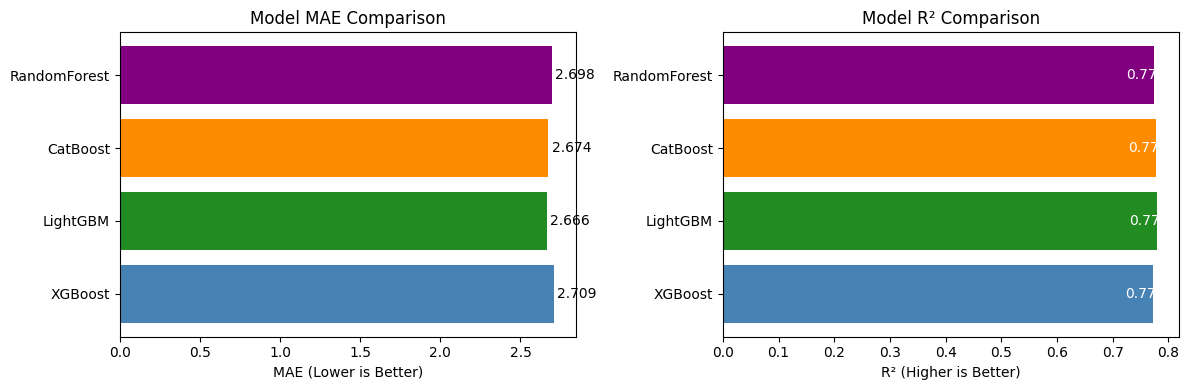

✅ Plot saved!


In [5]:
# CELL 20: MODEL COMPARISON PLOT (Without CNN-LSTM)

plt.figure(figsize=(12, 4))

# MAE Comparison
plt.subplot(1, 2, 1)
models = ['XGBoost', 'LightGBM', 'CatBoost', 'RandomForest']
maes = [mae_xgb, mae_lgb, mae_cb, mae_rf]
colors = ['steelblue', 'forestgreen', 'darkorange', 'purple']
plt.barh(models, maes, color=colors)
plt.xlabel('MAE (Lower is Better)')
plt.title('Model MAE Comparison')
for i, v in enumerate(maes):
    plt.text(v + 0.02, i, f'{v:.3f}', va='center')

# R² Comparison
plt.subplot(1, 2, 2)
r2s = [r2_xgb, r2_lgb, r2_cb, r2_rf]
plt.barh(models, r2s, color=colors)
plt.xlabel('R² (Higher is Better)')
plt.title('Model R² Comparison')
for i, v in enumerate(r2s):
    plt.text(v - 0.05, i, f'{v:.3f}', va='center', color='white')

plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/model_comparison.png", dpi=300)
plt.show()

print("✅ Plot saved!")

In [6]:
# CELL 21: CREATE 4-MODEL ENSEMBLE + CHECKPOINT 8

print("\n🌟 CREATING 4-MODEL ENSEMBLE...")

maes_4 = np.array([mae_xgb, mae_lgb, mae_cb, mae_rf])
weights_4 = (1 / maes_4) / (1 / maes_4).sum()
y_pred_ens_4 = weights_4[0]*y_pred_xgb + weights_4[1]*y_pred_lgb + weights_4[2]*y_pred_cb + weights_4[3]*y_pred_rf
mae_ens_4 = mean_absolute_error(y_test_unscaled, y_pred_ens_4)
r2_ens_4 = r2_score(y_test_unscaled, y_pred_ens_4)

print(f"📊 4-MODEL ENSEMBLE: MAE={mae_ens_4:.4f}, R²={r2_ens_4:.4f}")
print(f"   Weights: XGB={weights_4[0]:.3f}, LGB={weights_4[1]:.3f}, CB={weights_4[2]:.3f}, RF={weights_4[3]:.3f}")

ensemble_config = {
    'type': '4-model-tree',
    'models': ['xgb', 'lgb', 'cb', 'rf'],
    'weights': {'xgb': float(weights_4[0]), 'lgb': float(weights_4[1]), 'cb': float(weights_4[2]), 'rf': float(weights_4[3])},
    'metrics': {'mae': float(mae_ens_4), 'r2': float(r2_ens_4)}
}

with open(f"{OUTPUT_DIR}/ensemble_config.json", 'w') as f:
    json.dump(ensemble_config, f, indent=2)

print(f"✅ CHECKPOINT 8 SAVED - 4-model ensemble created")


🌟 CREATING 4-MODEL ENSEMBLE...
📊 4-MODEL ENSEMBLE: MAE=2.6628, R²=0.7806
   Weights: XGB=0.248, LGB=0.252, CB=0.251, RF=0.249
✅ CHECKPOINT 8 SAVED - 4-model ensemble created


📊 Creating comparison visualizations...


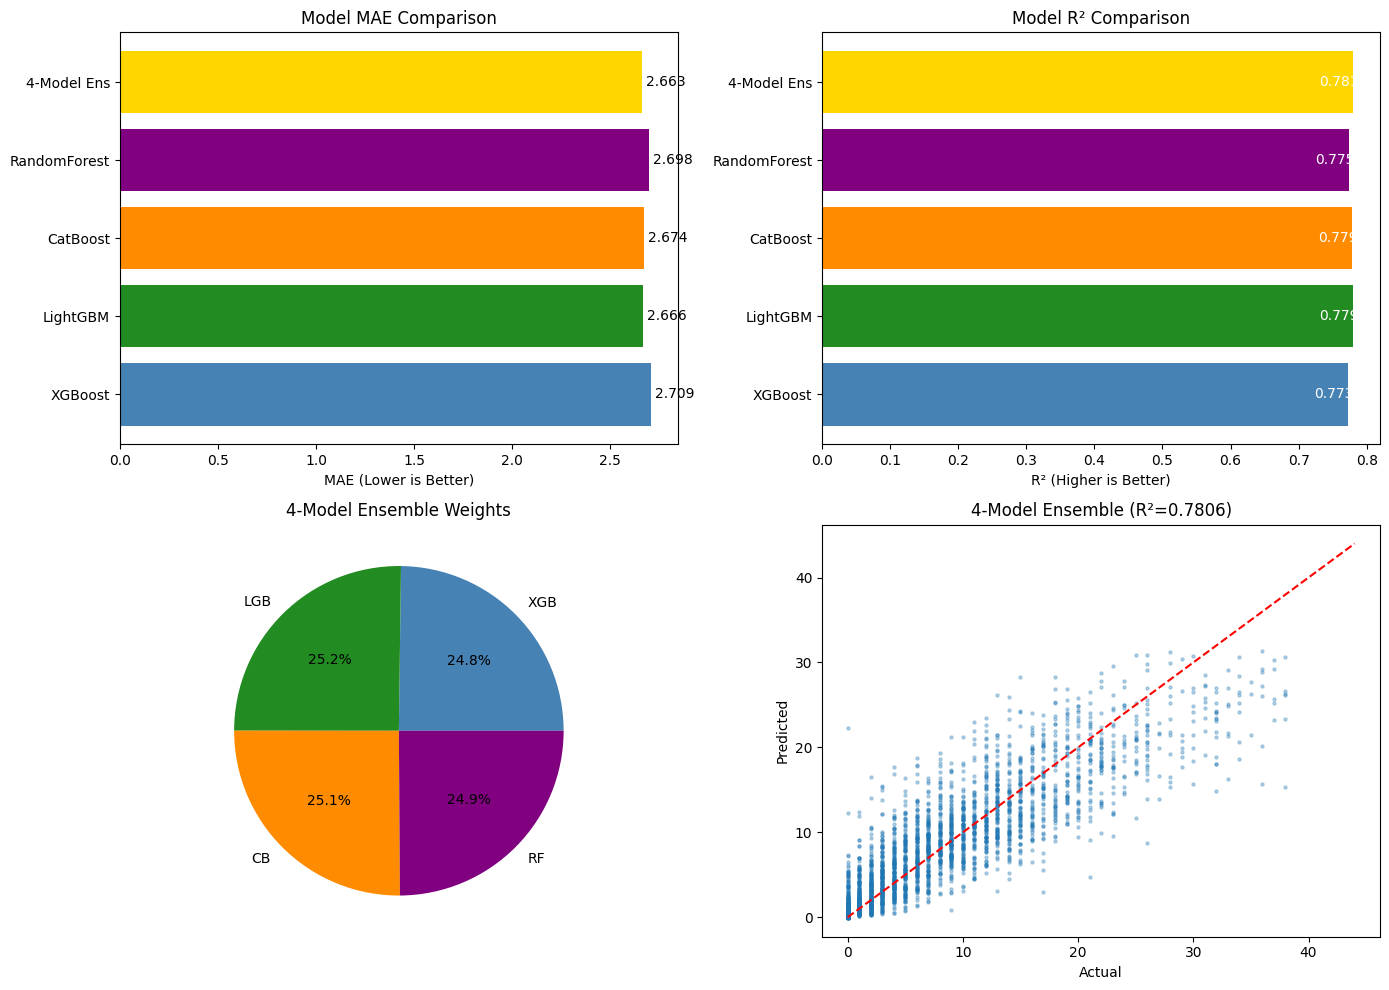

✅ Visualization saved!


In [10]:
# CELL 22: MODEL COMPARISON VISUALIZATION (4 Models Only)

print("📊 Creating comparison visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# MAE Comparison
ax1 = axes[0, 0]
models = ['XGBoost', 'LightGBM', 'CatBoost', 'RandomForest', '4-Model Ens']
maes = [mae_xgb, mae_lgb, mae_cb, mae_rf, mae_ens_4]
colors = ['steelblue', 'forestgreen', 'darkorange', 'purple', 'gold']
ax1.barh(models, maes, color=colors)
ax1.set_xlabel('MAE (Lower is Better)')
ax1.set_title('Model MAE Comparison')
for i, v in enumerate(maes):
    ax1.text(v + 0.02, i, f'{v:.3f}', va='center')

# R² Comparison
ax2 = axes[0, 1]
r2s = [r2_xgb, r2_lgb, r2_cb, r2_rf, r2_ens_4]
ax2.barh(models, r2s, color=colors)
ax2.set_xlabel('R² (Higher is Better)')
ax2.set_title('Model R² Comparison')
for i, v in enumerate(r2s):
    ax2.text(v - 0.05, i, f'{v:.3f}', va='center', color='white')

# 4-Model Weights Pie
ax3 = axes[1, 0]
ax3.pie(weights_4, labels=['XGB', 'LGB', 'CB', 'RF'], autopct='%1.1f%%', colors=colors[:4])
ax3.set_title('4-Model Ensemble Weights')

# Actual vs Predicted
ax4 = axes[1, 1]
sample = min(3000, len(y_test_unscaled))
idx = np.random.choice(len(y_test_unscaled), sample, replace=False)
ax4.scatter(y_test_unscaled[idx], y_pred_ens_4[idx], alpha=0.3, s=5)
ax4.plot([0, y_test_unscaled.max()], [0, y_test_unscaled.max()], 'r--')
ax4.set_xlabel('Actual')
ax4.set_ylabel('Predicted')
ax4.set_title(f'4-Model Ensemble (R²={r2_ens_4:.4f})')

plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/model_comparison.png", dpi=300)
plt.show()

print("✅ Visualization saved!")

In [12]:
# Load df_complete from checkpoint
df_complete = pd.read_parquet(f"{CHECKPOINT_DIR}/checkpoint_04_clean_data.parquet")
print(f"✅ Loaded df_complete: {len(df_complete):,} rows, {df_complete.shape[1]} columns")

✅ Loaded df_complete: 11,510,116 rows, 79 columns


In [15]:
# CELL 23: SAVE ALL DASHBOARD FILES

print("\n💾 SAVING DASHBOARD FILES...")

# Historical data parquet
dashboard_cols = ['station_name', 'time', 'pickups', 'dropoffs', 'net_demand', 'temp', 'prcp', 'wspd', 'coco',
                  'is_holiday', 'is_weekend', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
df_complete[dashboard_cols].to_parquet(f"{OUTPUT_DIR}/final_station_demand_robust_features.parquet", index=False)
print(f"✅ final_station_demand_robust_features.parquet ({len(df_complete):,} rows)")

# Reference data (last 60 days)
ref_cols = ['station_name', 'time', 'pickups', 'temp', 'prcp', 'wspd']
cutoff = df_complete['time'].max() - pd.Timedelta(days=60)
reference = df_complete[df_complete['time'] >= cutoff][ref_cols]
reference.to_parquet(f"{OUTPUT_DIR}/reference_data_recent.parquet", index=False)
print(f"✅ reference_data_recent.parquet ({len(reference):,} rows)")

# Station metadata
station_meta = df_complete.groupby('station_name')['pickups'].agg(['mean', 'std', 'max']).reset_index()
metadata = {row['station_name']: {'mean_demand': float(row['mean']), 'std_demand': float(row['std']) if not pd.isna(row['std']) else 1.0, 'max_demand': float(row['max'])} for _, row in station_meta.iterrows()}
with open(f"{OUTPUT_DIR}/station_metadata.json", 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ station_metadata.json ({len(metadata)} stations)")

# Top stations list
with open(f"{OUTPUT_DIR}/top_stations.json", 'w') as f:
    json.dump(top_stations, f)
print("✅ top_stations.json")

# Model summary (4 models only)
summary = {
    'training_date': TODAY,
    'data': {'stations': len(top_stations), 'train_rows': len(X_train), 'test_rows': len(X_test), 'features': len(FEATURE_COLS)},
    'models': {
        'xgb': {'mae': float(mae_xgb), 'r2': float(r2_xgb)},
        'lgb': {'mae': float(mae_lgb), 'r2': float(r2_lgb)},
        'cb': {'mae': float(mae_cb), 'r2': float(r2_cb)},
        'rf': {'mae': float(mae_rf), 'r2': float(r2_rf)}
    },
    'ensemble': {'mae': float(mae_ens_4), 'r2': float(r2_ens_4)}
}
with open(f"{OUTPUT_DIR}/model_summary.json", 'w') as f:
    json.dump(summary, f, indent=2)
print("✅ model_summary.json")

print("\n✅ All dashboard files saved!")


💾 SAVING DASHBOARD FILES...
✅ final_station_demand_robust_features.parquet (11,510,116 rows)
✅ reference_data_recent.parquet (281,267 rows)
✅ station_metadata.json (200 stations)
✅ top_stations.json
✅ model_summary.json

✅ All dashboard files saved!


In [18]:

# CELL 24: FINAL SUMMARY + CHECKPOINT 8 (FINAL)


print("\n" + "="*80)
print("🎉 TRAINING COMPLETE - FINAL SUMMARY")
print("="*80)

print(f"""
📅 DATE: {TODAY}
📁 OUTPUT: {OUTPUT_DIR}

📊 DATA:
   Stations: {len(top_stations)}
   Features: {len(FEATURE_COLS)}
   Train: {len(X_train):,} | Test: {len(X_test):,}
   Clean data (outliers removed)

📈 MODEL PERFORMANCE:
   XGBoost      - MAE: {mae_xgb:.4f}, R²: {r2_xgb:.4f}
   LightGBM     - MAE: {mae_lgb:.4f}, R²: {r2_lgb:.4f}
   CatBoost     - MAE: {mae_cb:.4f}, R²: {r2_cb:.4f}
   RandomForest - MAE: {mae_rf:.4f}, R²: {r2_rf:.4f}


   4-Model Ensemble - MAE: {mae_ens_4:.4f}, R²: {r2_ens_4:.4f} ⭐

📦 OUTPUT FILES:
   - xgb.json, lgb.pkl, cb.cbm, rf.pkl
   - cnn_lstm_model.keras
   - scaler_tree.save, scaler_y.save
   - feature_names.json
   - ensemble_config_4model.json
   - ensemble_config_5model.json
   - station_metadata.json
   - reference_data_recent.parquet
   - final_station_demand_robust_features.parquet

🚀 NEXT STEPS:
   1. Download files from {OUTPUT_DIR}
   2. Copy to backend/models/ and backend/data/v1_core/
   3. Update prediction_service.py if using 4/5-model ensemble
   4. Deploy and test!
""")

print(f"✅ CHECKPOINT 8 (FINAL) SAVED - All files ready for deployment!")
print("="*80)


🎉 TRAINING COMPLETE - FINAL SUMMARY

📅 DATE: 20251211
📁 OUTPUT: /content/drive/MyDrive/citi_bike_project_20251211/final_output

📊 DATA:
   Stations: 200
   Features: 54
   Train: 9,181,229 | Test: 2,295,308
   Clean data (outliers removed)

📈 MODEL PERFORMANCE:
   XGBoost      - MAE: 2.7088, R²: 0.7733
   LightGBM     - MAE: 2.6655, R²: 0.7795
   CatBoost     - MAE: 2.6742, R²: 0.7786
   RandomForest - MAE: 2.6977, R²: 0.7747
   
   
   4-Model Ensemble - MAE: 2.6628, R²: 0.7806 ⭐
   
📦 OUTPUT FILES:
   - xgb.json, lgb.pkl, cb.cbm, rf.pkl
   - cnn_lstm_model.keras
   - scaler_tree.save, scaler_y.save
   - feature_names.json
   - ensemble_config_4model.json
   - ensemble_config_5model.json
   - station_metadata.json
   - reference_data_recent.parquet
   - final_station_demand_robust_features.parquet

🚀 NEXT STEPS:
   1. Download files from /content/drive/MyDrive/citi_bike_project_20251211/final_output
   2. Copy to backend/models/ and backend/data/v1_core/
   3. Update prediction_servi